# Coursework 

- X1 = 120
- X2 = 98
Consider options with strike prices X1 and X2 of 4 types (European and
American puts and calls) with the time to maturity equal to 6 months (1/2 of
a year).
In total this amounts to 8 different options.
Suppose the following holds:
- current stock price S0 is 100p;
- annual volatility is 20%;
- money can be invested at the annual interest rate (with continuous com-
pounding) of 5% and the investment is virtually riskless; money can be
borrowed at the same rate.

# Imports

In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import norm

# Globals

In [2]:
enable_random_fixed_seed = True 

S0 = 100

# strike prices
X1 =  120
X2 = 98
 
T = 0.5
r = 0.05
sigma = 0.2

np.random.seed(0) if enable_random_fixed_seed else None
    
print(f"X1: {X1}")
print(f"X2: {X2}")

X1: 120
X2: 96


# Black Scholes Algorithm 

In [3]:
def bs(S0, K, T, r, sigma, option_type):
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (
        sigma * math.sqrt(T)
    )
    d2 = (math.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (
        sigma * math.sqrt(T)
    )
    if option_type == "call":
        return S0 * st.norm.cdf(d1) - K * math.exp(-r * T) * st.norm.cdf(d2)
    elif option_type == "put":
        return K * math.exp(-r * T) * st.norm.cdf(-d2) - S0 * st.norm.cdf(-d1)


# Mone_Carlo

In [4]:
def montecarlo(S0, K, T, r, sigma, option_type, n_simulations, n_steps):
    dt = T / n_steps
    stock_prices = np.zeros((n_simulations, n_steps + 1))
    stock_prices[:, 0] = S0
    for i in range(n_steps):
        eps = np.random.normal(0, 1, n_simulations)
        stock_prices[:, i + 1] = stock_prices[:, i] * np.exp(
            (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * eps
        )
    if option_type == "call":
        payoff = np.maximum(stock_prices[:, -1] - K, 0)
    elif option_type == "put":
        payoff = np.maximum(K - stock_prices[:, -1], 0)
    else:
        raise ValueError("Invalid option type")

    discounted_payoff = np.exp(-r * T) * payoff
    return np.mean(discounted_payoff)


# Binomial Tree

In [5]:
def trees(S0, K, T, r, sigma, option_type, n=1000, american=False):
    delta_t = T / n
    u = np.exp(sigma * np.sqrt(delta_t))
    d = 1 / u
    p = (np.exp(r * delta_t) - d) / (u - d)
    tree = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        for j in range(i + 1):
            tree[j, i] = S0 * (d**j) * (u ** (i - j))
    if option_type == "call":
        option_values = np.maximum(tree[:, -1] - K, 0)
    elif option_type == "put":
        option_values = np.maximum(K - tree[:, -1], 0)
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            option_values[j] = np.exp(-r * delta_t) * (
                p * option_values[j] + (1 - p) * option_values[j + 1]
            )
            if american:
                if option_type == "call":
                    option_values[j] = np.maximum(
                        option_values[j], tree[j, i] - K
                    )
                elif option_type == "put":
                    option_values[j] = np.maximum(
                        option_values[j], K - tree[j, i]
                    )
    return option_values[0]


### European call and put options computed from the Black-Scholes formula


In [6]:
print(
    f'EuCallX1BS: {bs(S0, X1, T, r, sigma, "call")}',
)
print(
    f'EuPutX1BS: {bs(S0, X1, T, r, sigma, "put")}',
)

print(
    f'EuCallX2BS: {bs(S0, X2, T, r, sigma, "call")}'
)
print(
    f'EuPutX2BS: {bs(S0, X2, T, r, sigma, "put")}',   
)


EuCallX1BS: 1.0226152225558849
EuPutX1BS: 18.05980466595578
EuCallX2BS: 9.222233623917731
EuPutX2BS: 2.8519851786376584


### European / American call and put options using Binomial trees 

In [7]:
print(f'EuCallX1Trees: {trees(S0, X1, T, r, sigma, "call")}') #European call with strike X1
print(f'EuPutX1Trees: {trees(S0, X1, T, r, sigma, "put")}') #European put with strike X1
print(f'AmCallX1Trees: {trees(S0, X1, T, r, sigma, "call", n=100, american=True)}')#American call with strike X1
print(f'AmPutX1Trees: {trees(S0, X1, T, r, sigma, "put", n=100, american=True)}')  #American put with strike X1

print(f'EuCallX2Trees: {trees(S0, X2, T, r, sigma, "call")}') #European call with strike X2
print(f'EuPutX2Trees: {trees(S0, X2, T, r, sigma, "put")}')  #European put with strike X2
print(f'AmCallX2Trees: {trees(S0, X2, T, r, sigma, "call", n=100, american=True)}') #American call with strike X2
print(f'AmPutX2Trees: {trees(S0, X2, T, r, sigma, "put", n=100, american=True)}') #American put with strike X2



EuCallX1Trees: 1.022732918809888
EuPutX1Trees: 18.059922362207374
AmCallX1Trees: 1.0244412096645743
AmPutX1Trees: 20.0
EuCallX2Trees: 9.22338575588147
EuPutX2Trees: 2.853137310598421
AmCallX2Trees: 9.233737648527985
AmPutX2Trees: 2.994488767883997


In [8]:

print(
    f'European call option price (Binomial Tree) => {X1}:',
    trees(S0, X1, T, r, sigma, "call"),
)
print(
    f"European put option price (Binomial Tree) => {X1}:",
    trees(S0, X1, T, r, sigma, "put"),
)
print(
    f"European call option price (Binomial Tree) => {X2}:",
    trees(S0, X2, T, r, sigma, "call"),
)
print(
    f"European put option price (Binomial Tree) => {X2}:",
    trees(S0, X2, T, r, sigma, "put"),
)
print(
    f"American call option price (Binomial Tree) => {X1}:",
    trees(S0, X1, T, r, sigma, "call", n=100, american=True),
)
print(
    f"American put option price (Binomial Tree) => {X1}:",
    trees(S0, X1, T, r, sigma, "put", n=100, american=True),
)
print(
    f"American call option price (Binomial Tree) => {X2}:",
    trees(S0, X2, T, r, sigma, "call", n=100, american=True),
)
print(
    f"American put option price (Binomial Tree) => {X2}:",
    trees(S0, X2, T, r, sigma, "put", n=100, american=True),
)


European call option price (Binomial Tree) => 120: 1.022732918809888
European put option price (Binomial Tree) => 120: 18.059922362207374
European call option price (Binomial Tree) => 96: 9.22338575588147
European put option price (Binomial Tree) => 96: 2.853137310598421
American call option price (Binomial Tree) => 120: 1.0244412096645743
American put option price (Binomial Tree) => 120: 20.0
American call option price (Binomial Tree) => 96: 9.233737648527985
American put option price (Binomial Tree) => 96: 2.994488767883997


# Monte Carlo Simulations

In [10]:
call1_bs = bs(S0, X1, T, r, sigma, "call")
put1_bs = bs(S0, X1, T, r, sigma, "put")
call2_bs = bs(S0, X2, T, r, sigma, "call")
put2_bs = bs(S0, X2, T, r, sigma, "put")


n_simulations = 100000
n_steps = 180

call1_mc =  montecarlo(S0, X1, T, r, sigma, "call", n_simulations, n_steps)
put1_mc =  montecarlo(S0, X1, T, r, sigma, "put", n_simulations, n_steps)
call2_mc =  montecarlo(S0, X2, T, r, sigma, "call", n_simulations, n_steps)
put2_mc =  montecarlo(S0, X2, T, r, sigma, "put", n_simulations, n_steps)

print(f'EuCallX1MC: {call1_mc}') #European call with strike X1
print(f'EuPutX1MC: {put1_mc}')  #European put with strike X1

print(f'EuCallX2MC: {call2_mc}') #European call with strike X2
print(f'EuPutX2MC: {put2_mc}')  #European put with strike X2

print("\n\n\n")
print("Theoretical European call option 1 price: ", call1_bs)
print("Monte Carlo European call option 1 price: ", call1_mc)
print("Theoretical European put option 1 price: ", put1_bs)
print("Monte Carlo European put option 1 price: ", put1_mc)
print("Theoretical European call option 2 price: ", call2_bs)
print("Monte Carlo European call option 2 price: ", call2_mc)
print("Theoretical European put option 2 price: ", put2_bs)
print("Monte Carlo European put option 2 price: ", put2_mc)


EuCallX1MC: 1.0190916590859989
EuPutX1MC: 18.06684285179912
EuCallX2MC: 9.164929097652038
EuPutX2MC: 2.8198603254371504




Theoretical European call option 1 price:  1.0226152225558849
Monte Carlo European call option 1 price:  1.0190916590859989
Theoretical European put option 1 price:  18.05980466595578
Monte Carlo European put option 1 price:  18.06684285179912
Theoretical European call option 2 price:  9.222233623917731
Monte Carlo European call option 2 price:  9.164929097652038
Theoretical European put option 2 price:  2.8519851786376584
Monte Carlo European put option 2 price:  2.8198603254371504


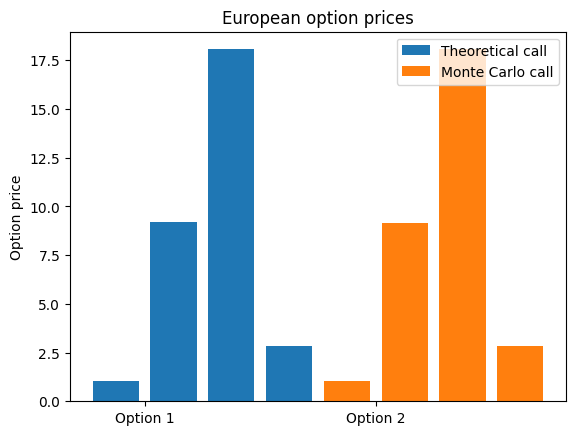

In [11]:
fig, ax = plt.subplots(1)
ax.bar([0, 1, 2, 3], [call1_bs, call2_bs, put1_bs,put2_bs, ])
ax.bar([4, 5, 6, 7], [call1_mc, call2_mc, put1_mc, put2_mc])


ax.set_xticks([0.5, 4.5])
ax.set_xticklabels(["Option 1", "Option 2"])
ax.set_ylabel("Option price")
ax.set_title("European option prices")
ax.legend(
    [
        "Theoretical call",
        "Monte Carlo call",
        "Theoretical put",
        "Monte Carlo put",
    ]
)
plt.show()
